In [1]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

import torch
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


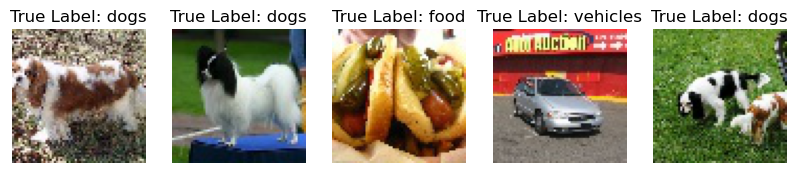

In [2]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

def load_and_preprocess_dataset(dataset_path):
    data = []
    labels = []

    categories = os.listdir(dataset_path)
    for category in categories:
        category_path = os.path.join(dataset_path, category)
        for filename in os.listdir(category_path):
            img_path = os.path.join(category_path, filename)
            img = np.array(Image.open(img_path).convert('RGB')) / 255.0
            data.append(img)
            labels.append(category)

    data, labels = shuffle(data, labels, random_state=42)

    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
    train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)

    label_encoder = LabelEncoder()
    train_labels = label_encoder.fit_transform(train_labels)
    val_labels = label_encoder.transform(val_labels)
    test_labels = label_encoder.transform(test_labels)

    return (
        torch.tensor(train_data, dtype=torch.float32),
        torch.tensor(val_data, dtype=torch.float32),
        torch.tensor(test_data, dtype=torch.float32),
        torch.tensor(train_labels, dtype=torch.long),
        torch.tensor(val_labels, dtype=torch.long),
        torch.tensor(test_labels, dtype=torch.long),
        label_encoder
    )


dataset_path = '/Users/siriduggineni/Downloads/cnn_dataset/'
train_data, val_data, test_data, train_labels, val_labels, test_labels, label_encoder = load_and_preprocess_dataset(dataset_path)

train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def show_images(images, labels, label_encoder, nrows, ncols):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(f"True Label: {label_encoder.inverse_transform([labels[i]])[0]}")
        ax.axis('off')
    plt.show()


images_to_show = 5
show_images(train_data[:images_to_show], train_labels[:images_to_show], label_encoder, 1, images_to_show)


In [3]:
data = []
labels = []

categories = os.listdir(dataset_path)
for category in categories:
    category_path = os.path.join(dataset_path, category)
    for filename in os.listdir(category_path):
        img_path = os.path.join(category_path, filename)
        img = np.array(Image.open(img_path).convert('RGB')) / 255.0
        data.append(img)
        labels.append(category)

    data, labels = shuffle(data, labels, random_state=42)

data = np.array(data)
labels = np.array(labels)

print("Dataset Shape:", data.shape)
print("Number of Classes:", len(np.unique(labels)))
print("Class Distribution:")
for class_name in np.unique(labels):
    class_count = np.sum(labels == class_name)
    print(f"{class_name}: {class_count} samples")


Dataset Shape: (30000, 64, 64, 3)
Number of Classes: 3
Class Distribution:
dogs: 10000 samples
food: 10000 samples
vehicles: 10000 samples


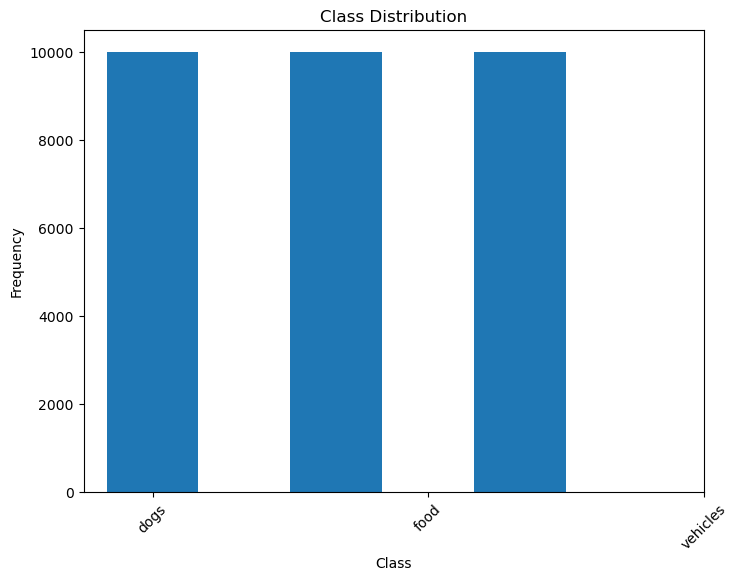

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(labels, bins=len(np.unique(labels)), align='left', rwidth=0.5)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.xticks(np.arange(len(np.unique(labels))), np.unique(labels), rotation=45)
plt.show()


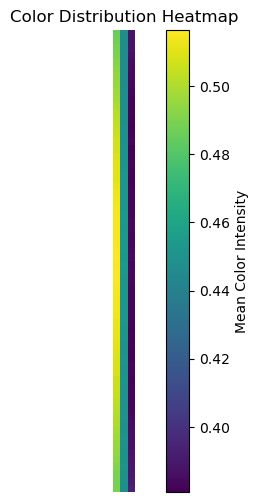

In [35]:
color_distribution = np.mean(data, axis=(0, 1))
plt.figure(figsize=(8, 6))
plt.imshow(color_distribution, cmap='viridis')
plt.title('Color Distribution Heatmap')
plt.colorbar(label='Mean Color Intensity')
plt.axis('off')
plt.show()

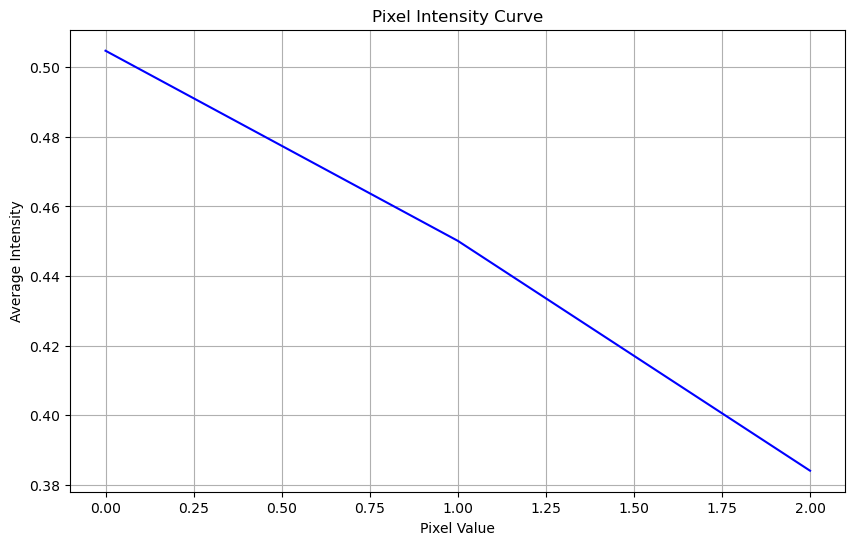

In [43]:
import numpy as np
import matplotlib.pyplot as plt

average_intensity = np.mean(data, axis=(0, 1, 2))

plt.figure(figsize=(10, 6))
plt.plot(average_intensity, color='blue')
plt.title('Pixel Intensity Curve')
plt.xlabel('Pixel Value')
plt.ylabel('Average Intensity')
plt.grid(True)
plt.show()


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn

class VGG13(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

vgg13 = VGG13()
print(vgg13)


VGG13(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16)

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch.nn.functional as F

summary(vgg13, (3,64,64))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg13.parameters(), lr=0.001)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

In [26]:
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

num_epochs = 3

start_time = time.time()

for epoch in range(num_epochs):
    vgg13.train()  
    epoch_train_loss = 0.0 
    correct_train = 0
    total_train = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
       
        data = data.permute(0, 3, 1, 2)
        output = vgg13(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        
        _, predicted_train = torch.max(output, 1)
        total_train += target.size(0)
        correct_train += (predicted_train == target).sum().item()

        if batch_idx % 100 == 0:
            print('Epoch {} Batch {}/{} Loss: {:.6f}'.format(epoch, batch_idx, len(train_loader), loss.item()))
   
    train_accuracy = correct_train / total_train
    print('Accuracy on the train dataset: {:.2%}'.format(train_accuracy))

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    vgg13.eval()
    correct_val = 0
    total_val = 0
    epoch_val_loss = 0.0  
    
    with torch.no_grad():
        for data, target in val_loader:
            data = data.permute(0, 3, 1, 2)
            output = vgg13(data)
            loss_val = criterion(output, target)
            epoch_val_loss += loss_val.item()

            _, predicted_val = torch.max(output, 1)
            total_val += target.size(0)
            correct_val += (predicted_val == target).sum().item()
    
    val_accuracy = correct_val / total_val
    print('Accuracy on the validation dataset: {:.2%}'.format(val_accuracy))

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)



Epoch 0 Batch 0/338 Loss: 6.905113
Epoch 0 Batch 100/338 Loss: 0.861451
Epoch 0 Batch 200/338 Loss: 0.701184
Epoch 0 Batch 300/338 Loss: 0.420056
Accuracy on the train dataset: 62.00%
Accuracy on the validation dataset: 78.67%
Epoch 1 Batch 0/338 Loss: 0.706484
Epoch 1 Batch 100/338 Loss: 0.705221
Epoch 1 Batch 200/338 Loss: 0.570087
Epoch 1 Batch 300/338 Loss: 0.393213
Accuracy on the train dataset: 81.88%
Accuracy on the validation dataset: 82.88%
Epoch 2 Batch 0/338 Loss: 0.401754
Epoch 2 Batch 100/338 Loss: 0.569637
Epoch 2 Batch 200/338 Loss: 0.266490
Epoch 2 Batch 300/338 Loss: 0.379228
Accuracy on the train dataset: 83.83%
Accuracy on the validation dataset: 82.67%


In [28]:
torch.save(vgg13.state_dict(), 'vgg13_baseModel.pth')

In [30]:
correct_test = 0
total_test = 0
epoch_test_loss = 0.0 
true_labels = []
predicted_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.permute(0, 3, 1, 2)
        output = vgg13(data)
        loss_test = criterion(output, target)
        epoch_test_loss += loss_test.item()

        _, predicted_test = torch.max(output, 1)
        total_test += target.size(0)
        correct_test += (predicted_test == target).sum().item()

        true_labels.extend(target.numpy())
        predicted_labels.extend(predicted_test.numpy())

        
test_accuracy = correct_test / total_test
print('Accuracy on the test dataset: {:.2%}'.format(test_accuracy))


precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 Score: {:.2f}'.format(f1_score))


Accuracy on the test dataset: 81.67%
Precision: 0.85
Recall: 0.82
F1 Score: 0.82


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(1000), yticklabels=np.arange(1000))
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


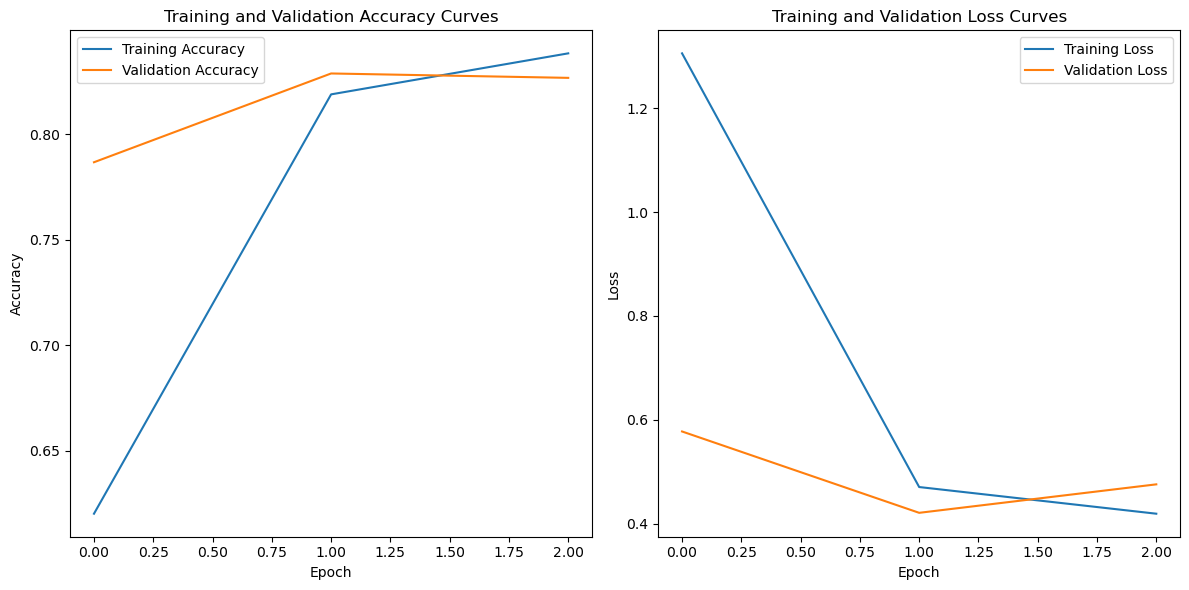

In [34]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, 3 ), train_accuracies, label='Training Accuracy')
plt.plot(np.arange(0, 3 ), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, 3 ), train_losses, label='Training Loss')
plt.plot(np.arange(0, 3 ), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



In [9]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch.nn.functional as F

vgg13_reg = VGG13()
summary(vgg13_reg, (3,64,64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

In [10]:
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

criterion_classification = nn.CrossEntropyLoss()

criterion_regularization = nn.L1Loss()

optimizer = optim.Adam(vgg13_reg.parameters(), lr=0.001, weight_decay=0.001)  

num_epochs = 3

for epoch in range(num_epochs):
    vgg13_reg.train() 
    epoch_train_loss = 0.0 
    correct_train = 0
    total_train = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.permute(0, 3, 1, 2)
        output = vgg13_reg(data)
        classification_loss = criterion_classification(output, target)
    
        l1_regularization_loss = 0
        for param in vgg13.parameters():
            l1_regularization_loss += criterion_regularization(param, torch.zeros_like(param))

        total_loss = classification_loss + l1_regularization_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        epoch_train_loss += total_loss.item()
        
        _, predicted_train = torch.max(output, 1)
        total_train += target.size(0)
        correct_train += (predicted_train == target).sum().item()

        if batch_idx % 100 == 0:
            print('Epoch {} Batch {}/{} Loss: {:.6f}'.format(epoch, batch_idx, len(train_loader), total_loss.item()))
    
    train_accuracy = correct_train / total_train
    print('Accuracy on the train dataset: {:.2%}'.format(train_accuracy))

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    vgg13_reg.eval()
    correct_val = 0
    total_val = 0
    epoch_val_loss = 0.0  
    
    with torch.no_grad():
        for data, target in val_loader:
            data = data.permute(0, 3, 1, 2)
            output = vgg13_reg(data)
            loss_val = criterion(output, target)
            epoch_val_loss += loss_val.item()

            _, predicted_val = torch.max(output, 1)
            total_val += target.size(0)
            correct_val += (predicted_val == target).sum().item()
    
    val_accuracy = correct_val / total_val
    print('Accuracy on the validation dataset: {:.2%}'.format(val_accuracy))

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    

Epoch 0 Batch 0/338 Loss: 7.369777
Epoch 0 Batch 100/338 Loss: 1.453482
Epoch 0 Batch 200/338 Loss: 1.477982
Epoch 0 Batch 300/338 Loss: 1.101671
Accuracy on the train dataset: 57.69%
Accuracy on the validation dataset: 74.46%
Epoch 1 Batch 0/338 Loss: 1.204917
Epoch 1 Batch 100/338 Loss: 0.886419
Epoch 1 Batch 200/338 Loss: 1.078159
Epoch 1 Batch 300/338 Loss: 0.926149
Accuracy on the train dataset: 79.80%
Accuracy on the validation dataset: 80.54%
Epoch 2 Batch 0/338 Loss: 1.087204
Epoch 2 Batch 100/338 Loss: 0.788136
Epoch 2 Batch 200/338 Loss: 0.814418
Epoch 2 Batch 300/338 Loss: 0.868820
Accuracy on the train dataset: 83.56%
Accuracy on the validation dataset: 84.79%


In [11]:
torch.save(vgg13_reg.state_dict(), 'vgg13_Model1.pth')

Accuracy on the test dataset: 85.23%
Precision: 0.86
Recall: 0.85
F1 Score: 0.85


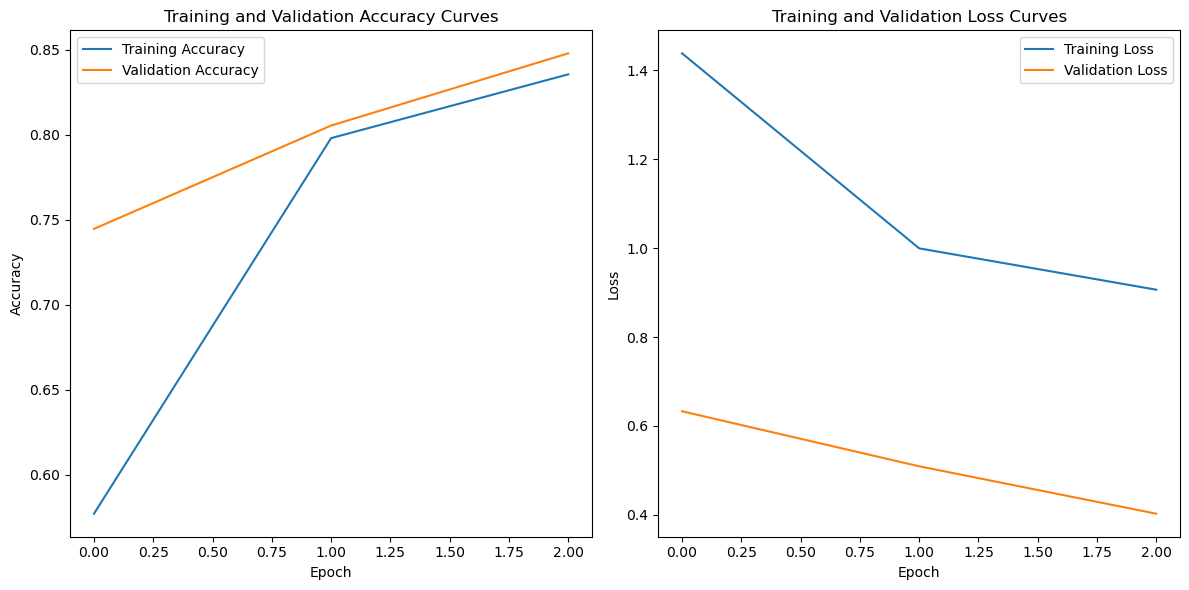

In [12]:
correct_test = 0
total_test = 0
epoch_test_loss = 0.0 
true_labels = []
predicted_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.permute(0, 3, 1, 2)
        output = vgg13_reg(data)
        loss_test = criterion(output, target)
        epoch_test_loss += loss_test.item()

        _, predicted_test = torch.max(output, 1)
        total_test += target.size(0)
        correct_test += (predicted_test == target).sum().item()

        true_labels.extend(target.numpy())
        predicted_labels.extend(predicted_test.numpy())

        
test_accuracy = correct_test / total_test
print('Accuracy on the test dataset: {:.2%}'.format(test_accuracy))


precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 Score: {:.2f}'.format(f1_score))


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, 3 ), train_accuracies, label='Training Accuracy')
plt.plot(np.arange(0, 3 ), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, 3 ), train_losses, label='Training Loss')
plt.plot(np.arange(0, 3 ), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()




In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(1000), yticklabels=np.arange(1000))
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn

class VGG13_2(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG13_2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 3),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
vgg13_2 = VGG13_2()



In [5]:
vgg13_2.to(device)

VGG13_2(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1

In [14]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch.nn.functional as F

summary(vgg13_2, (3,64,64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []


criterion_classification = nn.CrossEntropyLoss()

criterion_regularization = nn.L1Loss()

optimizer = optim.Adam(vgg13_2.parameters(), lr=0.001, weight_decay=0.001)  

num_epochs = 3

for epoch in range(num_epochs):
    vgg13_2.train()  
    epoch_train_loss = 0.0  
    correct_train = 0
    total_train = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.permute(0, 3, 1, 2)
        output = vgg13_2(data)
        classification_loss = criterion_classification(output, target)
        
        l1_regularization_loss = 0
        for param in vgg13_2.parameters():
            l1_regularization_loss += criterion_regularization(param, torch.zeros_like(param))
    
        total_loss = classification_loss + l1_regularization_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        epoch_train_loss += total_loss.item()
        
        _, predicted_train = torch.max(output, 1)
        total_train += target.size(0)
        correct_train += (predicted_train == target).sum().item()

        if batch_idx % 100 == 0:
            print('Epoch {} Batch {}/{} Loss: {:.6f}'.format(epoch, batch_idx, len(train_loader), total_loss.item()))
    
    train_accuracy = correct_train / total_train
    print('Accuracy on the train dataset: {:.2%}'.format(train_accuracy))

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    

    vgg13_2.eval()
    correct_val = 0
    total_val = 0
    epoch_val_loss = 0.0 
    
    with torch.no_grad():
        for data, target in val_loader:
            data = data.permute(0, 3, 1, 2)
            output = vgg13_2(data)
            loss_val = criterion_classification(output, target)
            epoch_val_loss += loss_val.item()

            _, predicted_val = torch.max(output, 1)
            total_val += target.size(0)
            correct_val += (predicted_val == target).sum().item()
    
    val_accuracy = correct_val / total_val
    print('Accuracy on the validation dataset: {:.2%}'.format(val_accuracy))

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    

Epoch 0 Batch 0/338 Loss: 1.568325
Epoch 0 Batch 100/338 Loss: 1.153979
Epoch 0 Batch 200/338 Loss: 1.101543
Epoch 0 Batch 300/338 Loss: 1.101264
Accuracy on the train dataset: 33.12%
Accuracy on the validation dataset: 33.96%
Epoch 1 Batch 0/338 Loss: 1.101252
Epoch 1 Batch 100/338 Loss: 1.101237
Epoch 1 Batch 200/338 Loss: 1.101216


In [20]:
torch.save(vgg13_2.state_dict(), 'vgg13_Model2.pth')

Accuracy on the test dataset: 33.48%
Precision: 0.11
Recall: 0.33
F1 Score: 0.17


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


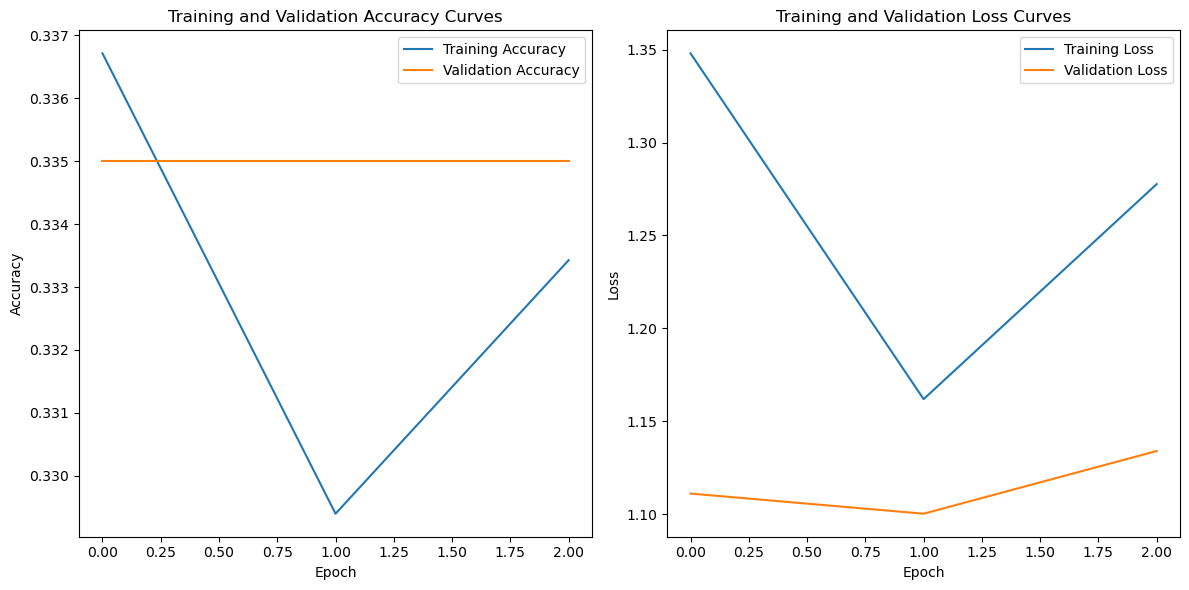

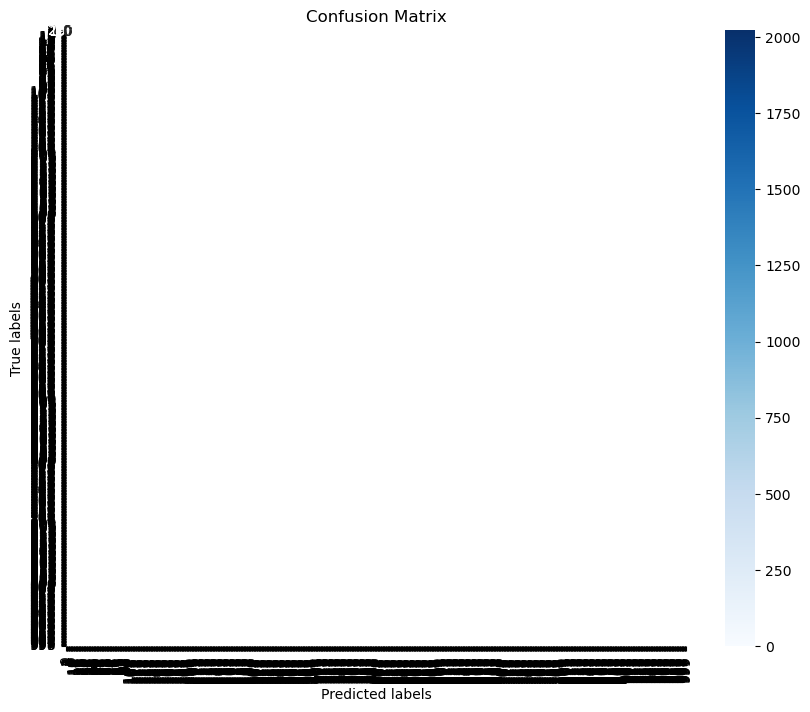

In [21]:
correct_test = 0
total_test = 0
epoch_test_loss = 0.0 
true_labels = []
predicted_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.permute(0, 3, 1, 2)
        output = vgg13_2(data)
        loss_test = criterion_classification(output, target)
        epoch_test_loss += loss_test.item()

        _, predicted_test = torch.max(output, 1)
        total_test += target.size(0)
        correct_test += (predicted_test == target).sum().item()

        true_labels.extend(target.numpy())
        predicted_labels.extend(predicted_test.numpy())

        
test_accuracy = correct_test / total_test
print('Accuracy on the test dataset: {:.2%}'.format(test_accuracy))


precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 Score: {:.2f}'.format(f1_score))


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, 3 ), train_accuracies, label='Training Accuracy')
plt.plot(np.arange(0, 3 ), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, 3 ), train_losses, label='Training Loss')
plt.plot(np.arange(0, 3 ), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(1000), yticklabels=np.arange(1000))
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()




In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn

class VGG13_2(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG13_2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(4096, 3),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch.nn.functional as F
vgg13_2 = VGG13_2()
summary(vgg13_2, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

In [5]:
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

criterion_classification = nn.CrossEntropyLoss()

criterion = nn.CrossEntropyLoss()

criterion_regularization = nn.L1Loss()

optimizer = optim.Adam(vgg13_2.parameters(), lr=0.001, weight_decay=0.001)  # Adjust weight_decay for desired regularization strength

num_epochs = 10
early_stopping_patience = 2
best_val_loss = float('inf')
best_epoch = 0
stop_training = False

for epoch in range(num_epochs):
    if stop_training:
        break
    vgg13_2.train()  
    epoch_train_loss = 0.0  
    correct_train = 0
    total_train = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.permute(0, 3, 1, 2)
        output = vgg13_2(data)
        classification_loss = criterion_classification(output, target)
        
        l1_regularization_loss = 0
        for param in vgg13_2.parameters():
            l1_regularization_loss += criterion_regularization(param, torch.zeros_like(param))
        
        total_loss = classification_loss + l1_regularization_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        epoch_train_loss += total_loss.item()
        
        _, predicted_train = torch.max(output, 1)
        total_train += target.size(0)
        correct_train += (predicted_train == target).sum().item()

        if batch_idx % 100 == 0:
            print('Epoch {} Batch {}/{} Loss: {:.6f}'.format(epoch, batch_idx, len(train_loader), total_loss.item()))
    
    train_accuracy = correct_train / total_train
    print('Accuracy on the train dataset: {:.2%}'.format(train_accuracy))

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    vgg13_2.eval()
    correct_val = 0
    total_val = 0
    epoch_val_loss = 0.0  
    
    with torch.no_grad():
        for data, target in val_loader:
            data = data.permute(0, 3, 1, 2)
            output = vgg13_2(data)
            loss_val = criterion(output, target)
            epoch_val_loss += loss_val.item()

            _, predicted_val = torch.max(output, 1)
            total_val += target.size(0)
            correct_val += (predicted_val == target).sum().item()
    
    val_accuracy = correct_val / total_val
    print('Accuracy on the validation dataset: {:.2%}'.format(val_accuracy))

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch
    else:
        if epoch - best_epoch >= early_stopping_patience:
            print("Early stopping at epoch", epoch)
            stop_training = True
            
            

NameError: name 'train_loader' is not defined

In [ ]:
torch.save(vgg13_2.state_dict(), 'vgg13_Model3.pth')

In [ ]:
correct_test = 0
total_test = 0
epoch_test_loss = 0.0 
true_labels = []
predicted_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.permute(0, 3, 1, 2)
        output = vgg13_2(data)
        loss_test = criterion(output, target)
        epoch_test_loss += loss_test.item()

        _, predicted_test = torch.max(output, 1)
        total_test += target.size(0)
        correct_test += (predicted_test == target).sum().item()

        true_labels.extend(target.numpy())
        predicted_labels.extend(predicted_test.numpy())

        
test_accuracy = correct_test / total_test
print('Accuracy on the test dataset: {:.2%}'.format(test_accuracy))


precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 Score: {:.2f}'.format(f1_score))


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, 3 ), train_accuracies, label='Training Accuracy')
plt.plot(np.arange(0, 3 ), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, 3 ), train_losses, label='Training Loss')
plt.plot(np.arange(0, 3 ), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(1000), yticklabels=np.arange(1000))
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


